## 1 - Introduction
This notebook is for clean the dataset downloaded from Lending Club website.

## 2 - Dataset

The dataset was download from [Lending Club](https://www.lendingclub.com/statistics/additional-statistics?). It contains information from 2015 to 2019. 

**Data manipulation**: 

    - Concatenate data from 2015 to 2019
    - Remove columns with >20% missing values
    - Save to a new csv file



In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from datetime import datetime
import time

# Options for pandas
pd.options.display.max_columns = 50
pd.options.display.max_rows = 30

import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

%load_ext autoreload
%autoreload 2

In [102]:
# read data
start = time.time()
path = '/Users/cyuancheng/Documents/course/Springboard/Capstone1/data/'
df = pd.read_csv(path+'data_col_pickup.csv', low_memory=True, index_col=0, \
                 parse_dates=['issue_d', 'earliest_cr_line', 'last_pymnt_d', 'issue_year'] )
end = time.time()
print('It takes  ' + str(end-start) +' sec to read the data')

It takes  39.1493182182312 sec to read the data


In [103]:
df.head()

,issue_d,earliest_cr_line,last_pymnt_d,issue_year,int_rate,revol_util,term,grade,emp_length,home_ownership,verification_status,loan_status,purpose,addr_state,loan_amnt,funded_amnt,installment,annual_inc,int_rate.1,dti,revol_bal,delinq_2yrs,open_acc,pub_rec,fico_range_high,fico_range_low,total_pymnt,recoveries
0,2015-12-01,2005-01-01,2018-08-01,2015-01-01,13.99,87.4,60 months,C,< 1 year,RENT,Source Verified,Fully Paid,credit_card,OH,21000.0,21000.0,488.53,52000.0,13.99,14.47,20374.0,0.0,5.0,0.0,684.0,680.0,27285.807861,0.0
1,2015-12-01,1997-06-01,2020-01-01,2015-01-01,12.88,24.1,60 months,C,10+ years,MORTGAGE,Not Verified,Current,debt_consolidation,MO,16800.0,16800.0,381.23,118000.0,12.88,34.29,7849.0,0.0,11.0,1.0,684.0,680.0,18650.220000,0.0
2,2015-12-01,1995-04-01,2020-01-01,2015-01-01,12.88,32.7,60 months,C,6 years,MORTGAGE,Not Verified,Current,debt_consolidation,SC,22400.0,22400.0,508.30,95000.0,12.88,22.98,13028.0,0.0,16.0,0.0,714.0,710.0,24866.630000,0.0
3,2015-12-01,2002-04-01,2018-08-01,2015-01-01,6.49,34.5,36 months,A,6 years,RENT,Not Verified,Fully Paid,credit_card,PA,10000.0,10000.0,306.45,85000.0,6.49,13.07,10464.0,0.0,14.0,1.0,689.0,685.0,10998.971575,0.0
4,2015-12-01,1994-11-01,2017-04-01,2015-01-01,11.48,39.1,36 months,B,10+ years,MORTGAGE,Not Verified,Fully Paid,credit_card,RI,8000.0,8000.0,263.74,42000.0,11.48,34.80,7034.0,0.0,8.0,0.0,704.0,700.0,8939.580503,0.0


In [104]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2307030 entries, 0 to 2312461
Data columns (total 28 columns):
issue_d                datetime64[ns]
earliest_cr_line       datetime64[ns]
last_pymnt_d           datetime64[ns]
issue_year             datetime64[ns]
int_rate               float64
revol_util             float64
term                   object
grade                  object
emp_length             object
home_ownership         object
verification_status    object
loan_status            object
purpose                object
addr_state             object
loan_amnt              float64
funded_amnt            float64
installment            float64
annual_inc             float64
int_rate.1             float64
dti                    float64
revol_bal              float64
delinq_2yrs            float64
open_acc               float64
pub_rec                float64
fico_range_high        float64
fico_range_low         float64
total_pymnt            float64
recoveries             float64

In [5]:
# check columns
print(sorted(df.columns))

['addr_state', 'annual_inc', 'delinq_2yrs', 'dti', 'earliest_cr_line', 'emp_length', 'fico_range_high', 'fico_range_low', 'funded_amnt', 'grade', 'home_ownership', 'installment', 'int_rate', 'int_rate.1', 'issue_d', 'issue_year', 'last_pymnt_d', 'loan_amnt', 'loan_status', 'open_acc', 'pub_rec', 'purpose', 'recoveries', 'revol_bal', 'revol_util', 'term', 'total_pymnt', 'verification_status']


In [105]:
print("Dataset has " + str(df.shape[0]) + " rows" +' and ' + str(df.shape[1]) + ' columns')

Dataset has 2307030 rows and 28 columns


### Target

In [106]:
df['loan_status'].value_counts(dropna=False)

Current               1017797
Fully Paid             994572
Charged Off            256642
Late (31-120 days)      22597
In Grace Period         10744
Late (16-30 days)        4619
Default                    48
Issued                     11
Name: loan_status, dtype: int64

In [107]:
# only select either 'Fully Paid' or 'Charged Off' for Target
df = df.loc[df['loan_status'].isin(["Fully Paid", "Charged Off"])]

In [108]:
# check missing value
df['loan_status'].isnull().sum()

0

In [109]:
# check distribution for binary classification
df['loan_status'].value_counts(normalize=True)

Fully Paid     0.794886
Charged Off    0.205114
Name: loan_status, dtype: float64

It looks like the target is imbalance

Next, tag the 'Fully Paid' to 0; 'Charged Off' to 1

In [110]:
# fully paid: 0, charged off:1
df['target'] = df['loan_status'].apply(lambda x:0 if x=='Fully Paid' else 1)
df['target'].value_counts(normalize=True) 

0    0.794886
1    0.205114
Name: target, dtype: float64

### Calculate loan period
calcluate the time period of the loan for each borrower
- `last payment date` minus `loan issue date`

In [111]:
df['loan_period'] = (df['last_pymnt_d'] - df['issue_d']) / np.timedelta64(1, 'M')

In [112]:
# remove loan_period = 0
df = df[df['loan_period']!=0]

(0, 0.1)

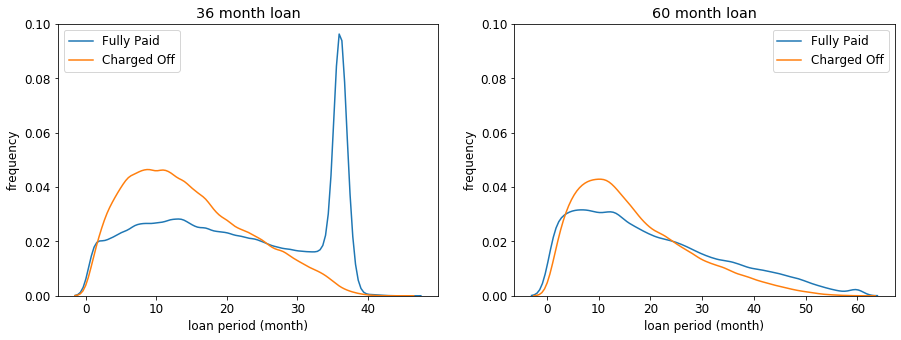

In [113]:
# compare loan period for 36 month vs 60 month loan
fig, (ax1, ax2) = plt.subplots(1, 2, sharex=False, figsize=(15,5))

sns.distplot(df[(df['target']==0) & (df['term']== ' 36 months')]['loan_period'], hist=False, \
             bins=50, rug=False, label = 'Fully Paid', ax=ax1)
sns.distplot(df[(df['target']==1) & (df['term']== ' 36 months')]['loan_period'], hist=False, \
             bins=50,rug=False, label = 'Charged Off', ax=ax1)

ax1.set_title('36 month loan')
ax1.set_xlabel('loan period (month)')
ax1.set_ylabel('frequency')
ax1.set_ylim([0, 0.1])

sns.distplot(df[(df['target']==0) & (df['term']== ' 60 months')]['loan_period'], hist=False, \
             bins=50,rug=False, label = 'Fully Paid', ax=ax2)
sns.distplot(df[(df['target']==1) & (df['term']== ' 60 months')]['loan_period'], hist=False, \
             bins=50,rug=False, label = 'Charged Off', ax=ax2)

ax2.set_title('60 month loan')
ax2.set_xlabel('loan period (month)')
ax2.set_ylabel('frequency')
ax2.set_ylim([0, 0.1])

For borrowers who have 36 month loan, they tend to pay off at the very end of their loans.

### Examine each column

In [114]:
df.columns

Index(['issue_d', 'earliest_cr_line', 'last_pymnt_d', 'issue_year', 'int_rate',
       'revol_util', 'term', 'grade', 'emp_length', 'home_ownership',
       'verification_status', 'loan_status', 'purpose', 'addr_state',
       'loan_amnt', 'funded_amnt', 'installment', 'annual_inc', 'int_rate.1',
       'dti', 'revol_bal', 'delinq_2yrs', 'open_acc', 'pub_rec',
       'fico_range_high', 'fico_range_low', 'total_pymnt', 'recoveries',
       'target', 'loan_period'],
      dtype='object')

List description for each column

In [115]:
df_description = pd.read_excel('LCDataDictionary.xlsx').dropna()
df_description_pick = df_description[df_description['LoanStatNew'].isin(df.columns)]
df_description_pick.style.set_properties(subset=['Description'], **{'width': '1000px'})

,LoanStatNew,Description
2,addr_state,The state provided by the borrower in the loan application
4,annual_inc,The self-reported annual income provided by the borrower during registration.
13,delinq_2yrs,The number of 30+ days past-due incidences of delinquency in the borrower's credit file for the past 2 years
16,dti,"A ratio calculated using the borrower’s total monthly debt payments on the total debt obligations, excluding mortgage and the requested LC loan, divided by the borrower’s self-reported monthly income."
18,earliest_cr_line,The month the borrower's earliest reported credit line was opened
19,emp_length,Employment length in years. Possible values are between 0 and 10 where 0 means less than one year and 10 means ten or more years.
21,fico_range_high,The upper boundary range the borrower’s FICO at loan origination belongs to.
22,fico_range_low,The lower boundary range the borrower’s FICO at loan origination belongs to.
23,funded_amnt,The total amount committed to that loan at that point in time.
25,grade,LC assigned loan grade


In [116]:
# show missing data
df.isnull().sum()[df.isnull().sum() >0]/len(df)*100

emp_length    6.804003
dti           0.068367
dtype: float64

In [117]:
#Drop the row where at least one element is missing.
df.dropna(axis=0, inplace=True)

In [118]:
# show missing data
df.isnull().sum()[df.isnull().sum() >0]/len(df)*100

Series([], dtype: float64)

In [119]:
# seperate dataframe: 'fully paid' vs 'charged off'
df_fp = df.loc[df['loan_status'] == 'Fully Paid']
df_co = df.loc[df['loan_status'] == 'Charged Off']

In [120]:
# make general plots to examine each feature
def plot_num(col_name, full_name):
    """
    Visualize a numerical variable with/without faceting on the loan status.
    - col_name is the variable name in the dataframe
    - full_name is the full variable name
    """
    plt.rcParams.update({'font.size': 12})
    fig, (ax1, ax2) = plt.subplots(1, 2, sharex=False, figsize=(15,4))
    # plot1: counts distribution of the variable
    #sns.distplot(df.loc[df[col_name].notnull(), col_name], kde=False, ax=ax1)
    #sns.distplot(df[col_name], kde=True,ax=ax1)
    sns.distplot(df_fp[col_name], hist=False, rug=False, label = 'Fully Paid', ax=ax1)
    sns.distplot(df_co[col_name], hist=False, rug=False, label = 'Charged Off', ax=ax1)
    
    ax1.set_xlabel(full_name)
    ax1.set_ylabel('Count')
    ax1.set_title(full_name)
    #plt.show()
          
    # plot2: box plot of the variable grouped by loan_status
    sns.boxplot(x=col_name, y='loan_status', data=df, ax=ax2)
    ax2.set_xlabel(full_name)
    ax2.set_ylabel('')
    ax2.set_title(full_name)
  
    plt.tight_layout()

In [199]:
def plot_cat(col_name, full_name, height=5):
    """
    Visualize a numerical variable with/without faceting on the loan status.
    - col_name is the variable name in the dataframe
    - full_name is the full variable name
    """

    plt.rcParams.update({'font.size': 12})
    fig, (ax1, ax2) = plt.subplots(1, 2, sharex=False, figsize=(15,height))
    # plot1: counts distribution of the variable
    sns.countplot(y=col_name, data = df, hue='loan_status',order = df[col_name].value_counts().index, ax=ax1)
    ax1.set_xlabel('Count')
    ax1.set_ylabel('')
    ax1.set_title(full_name)

    #plt.show()
          
    # plot2: box plot of the variable grouped by loan_status
    charged_off_rate = df.groupby(col_name)['loan_status']\
    .value_counts(normalize=True)[:,'Charged Off'].sort_values(ascending=False)
    
    sns.barplot(y=charged_off_rate.index, x=charged_off_rate.values, color = 'steelblue',ax=ax2)
    ax2.set_xlabel('Charged off rate')
    ax2.set_ylabel('')
    ax2.set_title(full_name)

    plt.tight_layout()


#### 1) `issue_d`
- The month which the loan was funded


In [23]:
df['issue_d'].describe()

count                 1238903
unique                     60
top       2016-03-01 00:00:00
freq                    56490
first     2015-01-01 00:00:00
last      2019-12-01 00:00:00
Name: issue_d, dtype: object

In [25]:
print('missing value = '+str(df['issue_d'].isnull().sum()))

missing value = 0


#### 2) `earliest_cr_line`
- The month the borrower's earliest reported credit line was opened

In [26]:
df['earliest_cr_line'].describe()

count                 1238903
unique                    742
top       2004-09-01 00:00:00
freq                     9181
first     1933-03-01 00:00:00
last      2016-10-01 00:00:00
Name: earliest_cr_line, dtype: object

In [27]:
print('missing value = '+str(df['earliest_cr_line'].isnull().sum()))

missing value = 0


#### 3) `last_pymnt_d`
- Last month payment was received

In [28]:
df['last_pymnt_d'].describe()

count                 1238903
unique                     61
top       2019-04-01 00:00:00
freq                    39528
first     2015-02-01 00:00:00
last      2020-02-01 00:00:00
Name: last_pymnt_d, dtype: object

In [29]:
print('missing value = '+str(df['last_pymnt_d'].isnull().sum()))

missing value = 0


#### 4) `issue_year`


In [30]:
df['issue_year'].describe()

count                 1238903
unique                      5
top       2016-01-01 00:00:00
freq                   394433
first     2015-01-01 00:00:00
last      2019-01-01 00:00:00
Name: issue_year, dtype: object

#### 5) `int_rate`
- Interest Rate on the loan

In [31]:
df['int_rate'].describe()

count    1.238903e+06
mean     1.293648e+01
std      4.934891e+00
min      5.310000e+00
25%      9.170000e+00
50%      1.229000e+01
75%      1.561000e+01
max      3.099000e+01
Name: int_rate, dtype: float64

In [32]:
print('missing value = '+str(df['int_rate'].isnull().sum()))

missing value = 0


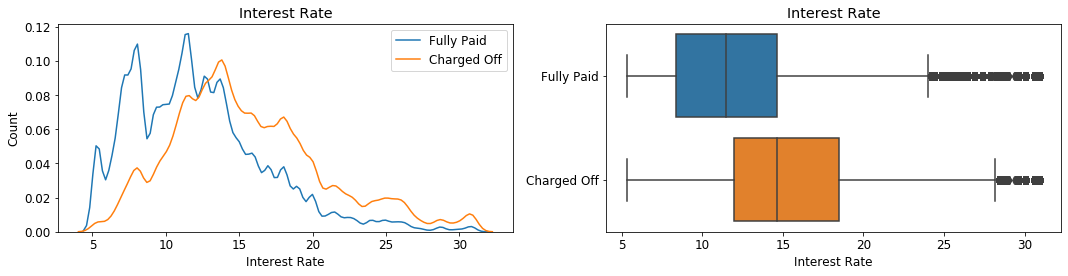

In [51]:
plot_num('int_rate', 'Interest Rate')

#### 6) `revol_util`
- Revolving line utilization rate, or the amount of credit the borrower is using relative to all available revolving credit

In [52]:
df['revol_util'].describe()

count    1.238903e+06
mean     4.893088e+01
std      2.476853e+01
min      0.000000e+00
25%      3.000000e+01
50%      4.850000e+01
75%      6.780000e+01
max      1.930000e+02
Name: revol_util, dtype: float64

In [53]:
print('missing value = '+str(df['revol_util'].isnull().sum()))

missing value = 0


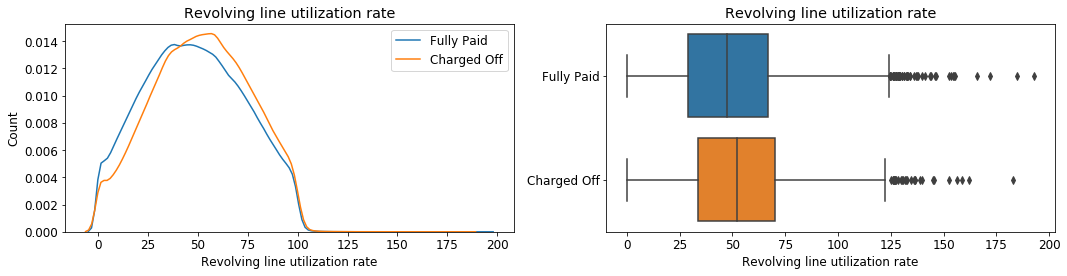

In [54]:
plot_num('revol_util', 'Revolving line utilization rate')

#### 7) `term`
- The number of payments on the loan. Values are in months and can be either 36 or 60.

In [55]:
df['term'].describe()

count        1238903
unique             2
top        36 months
freq          944502
Name: term, dtype: object

In [56]:
print('missing value = '+str(df['term'].isnull().sum()))

missing value = 0


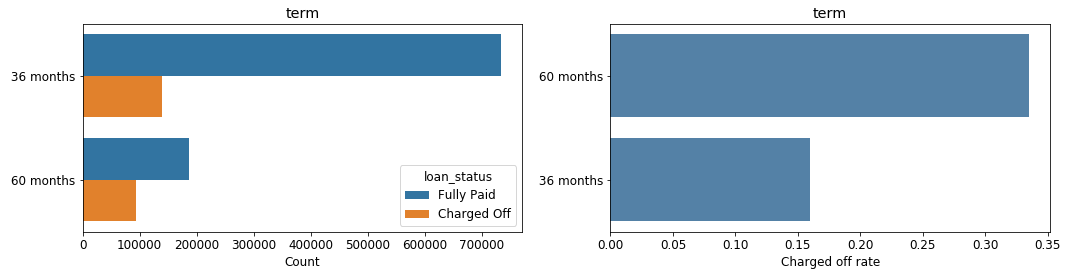

In [192]:
plot_cat('term', 'term')

#### 8) `grade`
- LC assigned loan grade

In [66]:
df['grade'].describe()

count     1238903
unique          7
top             B
freq       364119
Name: grade, dtype: object

In [67]:
print('missing value = '+str(df['grade'].isnull().sum()))

missing value = 0


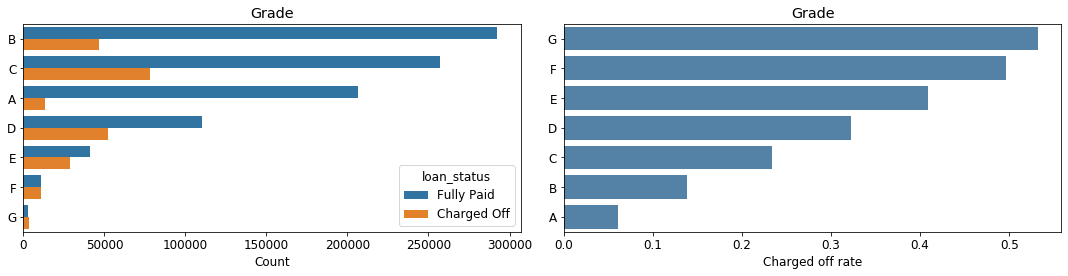

In [193]:
plot_cat('grade', 'Grade')

#### 9) `emp_length`
- Employment length in years. Possible values are between 0 and 10 where 0 means less than one year and 10 means ten or more years

In [69]:
df['emp_length'].describe()

count       1154608
unique           11
top       10+ years
freq         411220
Name: emp_length, dtype: object

In [70]:
print('missing value = '+str(df['emp_length'].isnull().sum()))

missing value = 84295


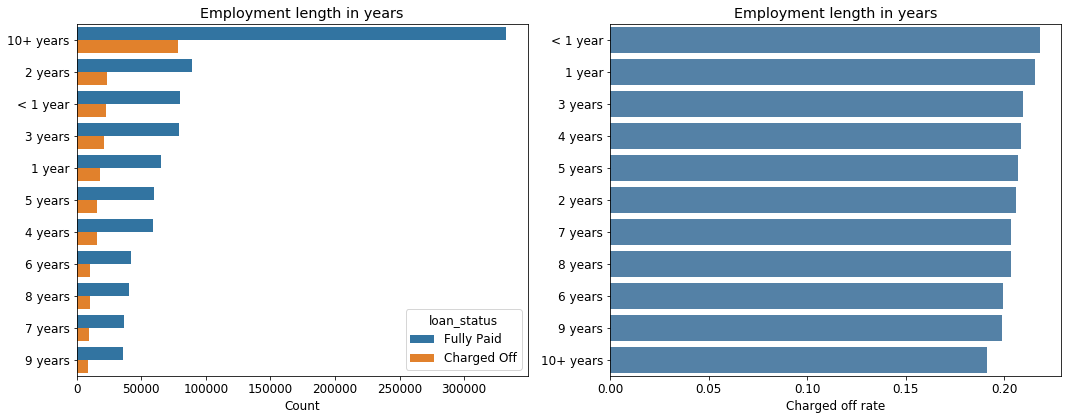

In [204]:
#df.columns#['emp_length'].head()
plot_cat('emp_length', 'Employment length in years',6)

#### 10) `'home_ownership'`
- The home ownership status provided by the borrower during registration or obtained from the credit report. Our values are: RENT, OWN, MORTGAGE, OTHER

In [135]:
df['home_ownership'].describe()

count      1154553
unique           5
top       MORTGAGE
freq        568337
Name: home_ownership, dtype: object

In [137]:
df['home_ownership'].value_counts()

MORTGAGE    568337
RENT        458001
OWN         127429
ANY            784
NONE             2
Name: home_ownership, dtype: int64

In [143]:
# drop NONE
df = df[df['home_ownership']!='NONE']
df['home_ownership'].value_counts()

MORTGAGE    568337
RENT        458001
OWN         127429
ANY            784
Name: home_ownership, dtype: int64

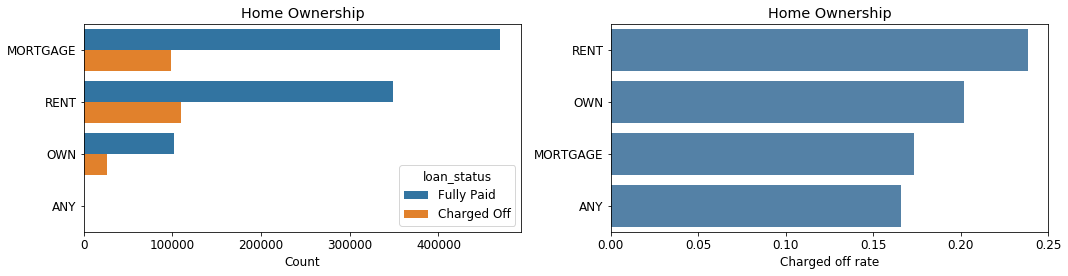

In [195]:
plot_cat('home_ownership', 'Home Ownership')

#### 11) `verification_status`
- Indicates if income was verified by LC, not verified, or if the income source was verified


In [145]:
df['verification_status'].describe()

count             1154551
unique                  3
top       Source Verified
freq               501776
Name: verification_status, dtype: object

In [147]:
df['verification_status'].unique()

array(['Source Verified', 'Not Verified', 'Verified'], dtype=object)

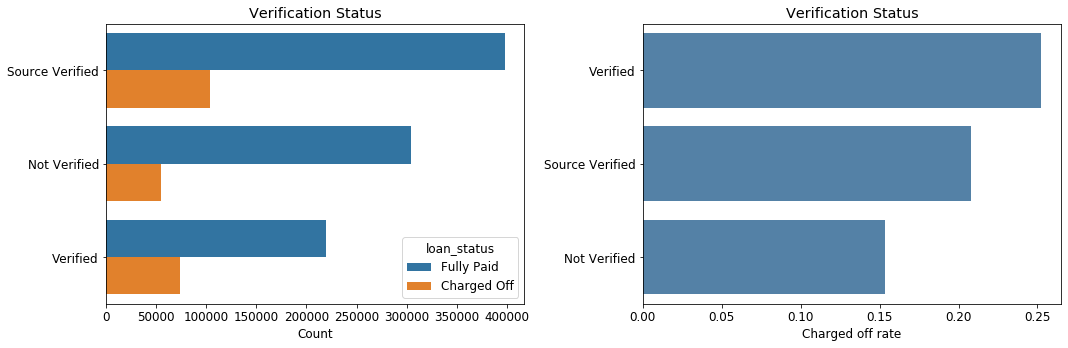

In [203]:
plot_cat('verification_status', 'Verification Status')

#### 12) `'purpose'`
- A category provided by the borrower for the loan request.

In [149]:
df['purpose'].describe()

count                1154551
unique                    14
top       debt_consolidation
freq                  660155
Name: purpose, dtype: object

In [150]:
df['purpose'].unique()

array(['credit_card', 'major_purchase', 'debt_consolidation',
       'small_business', 'home_improvement', 'other', 'house', 'medical',
       'car', 'vacation', 'moving', 'renewable_energy', 'wedding',
       'educational'], dtype=object)

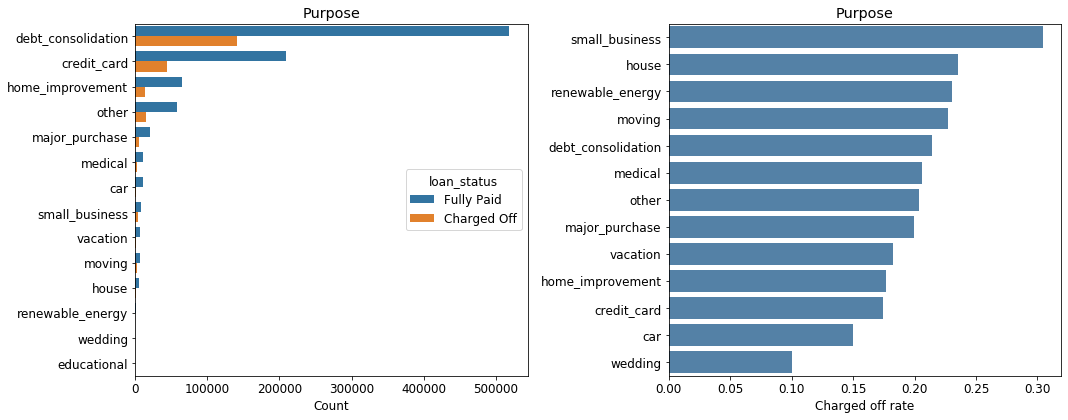

In [202]:
plot_cat('purpose', 'Purpose',6)

#### 13) `addr_state`
- The state provided by the borrower in the loan application

In [152]:
df['addr_state'].describe()

count     1154551
unique         50
top            CA
freq       161641
Name: addr_state, dtype: object

In [153]:
df['addr_state'].unique()

array(['OH', 'PA', 'RI', 'SC', 'NC', 'AZ', 'VA', 'NY', 'KS', 'AL', 'NM',
       'TX', 'MD', 'WA', 'GA', 'LA', 'IL', 'CO', 'FL', 'MI', 'MO', 'IN',
       'WI', 'CA', 'VT', 'TN', 'MA', 'NJ', 'OR', 'SD', 'MN', 'DC', 'DE',
       'NH', 'NE', 'AR', 'NV', 'MT', 'WV', 'HI', 'OK', 'WY', 'KY', 'CT',
       'MS', 'UT', 'ND', 'ME', 'AK', 'ID'], dtype=object)

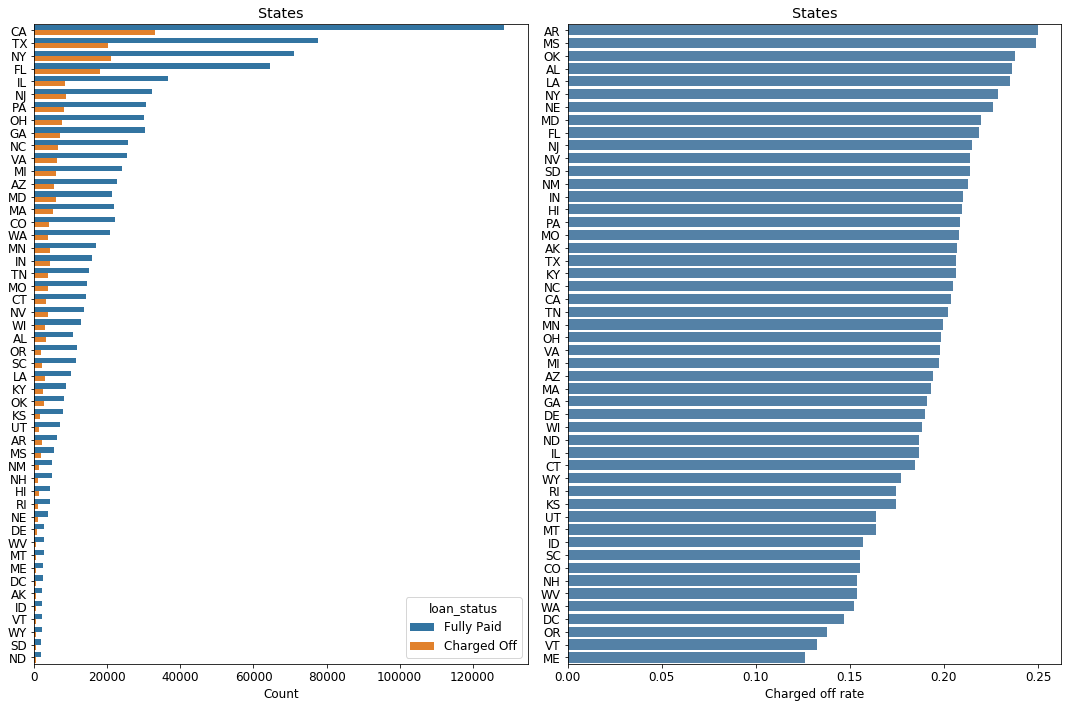

In [201]:
plot_cat('addr_state', 'States',10)